# Creating a dataset that combines images with 2 objects and 1 object. 

In [1]:
import os
import json
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from diffusers import AutoencoderKL
from tqdm.notebook import tqdm
from datasets import load_dataset
from PIL import Image, ImageDraw
from os.path import join


/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# Refer to the double object and single object classes made previously

In [2]:

class SingleShapeDataset(Dataset):
    def __init__(self, num_images, resolution=64, radius=16, transform=None):
        self.num_images = num_images
        self.shapes = ['triangle', 'circle', 'square']
        self.colors = ['red', 'blue']
        self.articles = ['a', 'an', 'the', 'or', '']
        self.canvas_size = resolution
        self.radius = radius
        self.transform = transform 
        self.shape_to_idx = {'triangle': 0, 'circle': 1, 'square': 2}
        self.color_to_rgb = {'red': 'red', 'blue': 'blue'}

    def __len__(self):
        return self.num_images
    
    def draw_shape_on_image(self, img, shape, location, color):
        draw = ImageDraw.Draw(img)
        x, y = location
        
        if shape == 'circle':
            r = self.radius
            draw.ellipse([(x - r, y - r), (x + r, y + r)], fill=color)
        elif shape == 'square':
            s = self.radius * 2
            draw.rectangle([(x - s//2, y - s//2), (x + s//2, y + s//2)], fill=color)
        elif shape == 'triangle':
            s = self.radius * 2
            h = s * (3 ** 0.5) / 2
            point1 = (x, y - h / 3)
            point2 = (x - s / 2, y + h * 2 / 3)
            point3 = (x + s / 2, y + h * 2 / 3)
            draw.polygon([point1, point2, point3], fill=color)

        return img
    

    def __getitem__(self, idx):
        # Blank image
        img = Image.new('RGB', (self.canvas_size, self.canvas_size), 'gray')

        # Randomly select shape and color
        include_color = random.random() < 0.8
        shape = random.choice(self.shapes)
        color = random.choice(self.colors)
        article = random.choice(self.articles)

        components = [article, color, shape]
        caption = f"{article} {color if include_color else ''} {shape.lstrip()}".strip()

        # Random location
        x = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)

        # Draw the shape
        img = self.draw_shape_on_image(img, shape, (x, y), color=self.color_to_rgb[color])

        # Convert image
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        labels = {
            'shape': self.shape_to_idx[shape],
            'location': torch.tensor([x, y], dtype=torch.float32),
            'caption': caption
        }

        return img, labels


In [3]:
class DoubleShapeDataset(Dataset):
    def __init__(self, num_images, resolution=64, radius=16, transform=None):
        """
        Initializes the dataset.

        Parameters:
        - num_images: Integer specifying the number of images in the dataset.
        - transform: Optional torchvision transforms to apply to the images.
        """
        self.num_images = num_images
        self.shapes = ['triangle', 'circle', 'square']
        self.canvas_size = resolution
        self.transform = transform
        self.shape_to_idx = {'triangle': 0, 'circle': 1, 'square': 2}
        self.idx_to_shape = {0: 'triangle', 1: 'circle', 2: 'square'}
        self.radius = radius

        # Spatial relationship phrases for variety
        self.spatial_phrases = {
            'upper_left': ['to the upper left of', 'above and to the left of', 'diagonally up and left from'],
            'upper_right': ['to the upper right of', 'above and to the right of', 'diagonally up and right from'],
            'lower_left': ['to the lower left of', 'below and to the left of', 'diagonally down and left from'],
            'lower_right': ['to the lower right of', 'below and to the right of', 'diagonally down and right from'],
            'above': ['above', 'directly above', 'higher than'],
            'below': ['below', 'directly below', 'lower than'],
            'left': ['to the left of', 'left of', 'left'],
            'right': ['to the right of', 'right of', 'right']
        }

    def generate_caption(self, shape1_idx, shape2_idx, loc1, loc2):
        """
        Generates a natural language caption describing the spatial relationship between two shapes.
        
        Parameters:
        - shape1_idx: Index of first shape
        - shape2_idx: Index of second shape
        - loc1: Coordinates of first shape (x, y)
        - loc2: Coordinates of second shape (x, y)
        
        Returns:
        - string: A natural language caption describing the scene
        """
        # Get shape names
        shape1_name = self.idx_to_shape[shape1_idx]
        shape2_name = self.idx_to_shape[shape2_idx]
        
        # Get coordinates
        x1, y1 = loc1
        x2, y2 = loc2
        
        # Calculate position differences
        dx = x1 - x2  # Positive means shape1 is to the right
        dy = y1 - y2  # Positive means shape1 is lower
        
        # Define thresholds for "directly" above/below/left/right
        threshold = 5  # pixels
        
        # Determine spatial relationship
        if abs(dx) <= threshold:  # Roughly aligned vertically
            if dy < 0:
                relation = random.choice(self.spatial_phrases['above'])
            else:
                relation = random.choice(self.spatial_phrases['below'])
        elif abs(dy) <= threshold:  # Roughly aligned horizontally
            if dx < 0:
                relation = random.choice(self.spatial_phrases['left'])
            else:
                relation = random.choice(self.spatial_phrases['right'])
        else:  # Diagonal relationship
            if dx < 0 and dy < 0:
                relation = random.choice(self.spatial_phrases['upper_left'])
            elif dx < 0 and dy > 0:
                relation = random.choice(self.spatial_phrases['lower_left'])
            elif dx > 0 and dy < 0:
                relation = random.choice(self.spatial_phrases['upper_right'])
            else:  # dx > 0 and dy > 0
                relation = random.choice(self.spatial_phrases['lower_right'])
        
        # Construct caption
        caption = f"{shape1_name} is {relation} {shape2_name}"
        return caption

    def __len__(self):
        return self.num_images

    def draw_shape_on_image(self, img, shape, location, color='black'):
        """
        Draws a specified shape at a given location on the provided image.

        Parameters:
        - img: PIL Image object to draw on.
        - shape: String specifying the shape ('triangle', 'circle', 'square').
        - location: Tuple (x, y) specifying the location of the shape's center.

        Returns:
        - img: PIL Image object with the shape drawn on it.
        """
        draw = ImageDraw.Draw(img)
        x, y = location

        if shape == 'circle':
            r = self.radius  # Radius
            leftUpPoint = (x - r, y - r)
            rightDownPoint = (x + r, y + r)
            draw.ellipse([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'square':
            s = self.radius * 2  # Side length
            leftUpPoint = (x - s // 2, y - s // 2)
            rightDownPoint = (x + s // 2, y + s // 2)
            draw.rectangle([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'triangle':
            s = self.radius * 2  # Side length
            h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
            point1 = (x, y - h / 3)
            point2 = (x - s / 2, y + h * 2 / 3)
            point3 = (x + s / 2, y + h * 2 / 3)
            draw.polygon([point1, point2, point3], fill=color)

        else:
            raise ValueError("Shape must be 'triangle', 'circle', or 'square'.")

        return img

    def __getitem__(self, idx):
        """
        Generates one image and its labels.

        Parameters:
        - idx: Index of the image (not used as images are generated on-the-fly).

        Returns:
        - img: Tensor representing the image.
        - labels: Dictionary containing the shapes and locations of the objects.
        """
        # Create a blank image
        img = Image.new('RGB', (self.canvas_size, self.canvas_size), 'gray')

        # Randomly select two shapes, make sure they are different
        shape1 = random.choice(self.shapes)
        while True:
            shape2 = random.choice(self.shapes)
            if shape1 != shape2:
                break

        # Randomly select locations
        x1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        x2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)

        # Randomly decide drawing order to allow overlapping
        if random.random() < 0.5:
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            shapes_order = [shape1, shape2]
            locations_order = [(x1, y1), (x2, y2)]
        else:
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            shapes_order = [shape2, shape1]
            locations_order = [(x2, y2), (x1, y1)]

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Encode labels and generate caption
        shape1_idx = self.shape_to_idx[shapes_order[0]]
        shape2_idx = self.shape_to_idx[shapes_order[1]]
        location1 = torch.tensor(locations_order[0], dtype=torch.float32)
        location2 = torch.tensor(locations_order[1], dtype=torch.float32)
        
        caption = self.generate_caption(shape1_idx, shape2_idx, locations_order[0], locations_order[1])

        labels = {
            'shape1': shape1_idx,
            'location1': location1,
            'shape2': shape2_idx,
            'location2': location2,
            'caption': caption
        }

        return img, labels


# Create the Mixed Object Wrapper

In [4]:
class MixedShapesDataset(Dataset):
    def __init__(self, single_dataset, double_dataset, single_ratio=0.3, total_length=10000):
        self.single_dataset = single_dataset
        self.double_dataset = double_dataset
        self.single_ratio = single_ratio 

        if total_length is None:
            self.length = len(single_dataset) + len(double_dataset)
        else:
            self.length = total_length 

        num_single = int(self.length * self.single_ratio)
        num_double = self.length - num_single
        self.sample_types = ['single'] * num_single + ['double'] * num_double
        random.shuffle(self.sample_types)

        self.single_indices = list(range(len(single_dataset)))
        self.double_indices = list(range(len(double_dataset)))
        random.shuffle(self.single_indices)
        random.shuffle(self.double_indices)

        self.single_ptr = 0
        self.double_ptr = 0
        self.type_to_idx = {'single': 0, 'double': 1,}
        self.idx_to_type = {0: 'single', 1: 'double'}

    def __len__(self):
        return self.length 

    def __getitem__(self, idx):
        sample_type = self.sample_types[idx]
        if sample_type == 'single':
            if self.single_ptr >= len(self.single_indices):
                self.single_ptr = 0
                random.shuffle(self.single_indices)
            img, labels = self.single_dataset[self.single_indices[self.single_ptr]]
            self.single_ptr += 1

         # Convert to double-object format for consistency
            new_labels = {
                'shape1': labels['shape'],
                'location1': labels['location'],
                'shape2': -1,
                'location2': torch.tensor([-1, -1]),
                'caption': labels['caption'],
                'type': self.type_to_idx['single']
            }
            return img, new_labels
        else:
            if self.double_ptr >= len(self.double_indices):
                self.double_ptr = 0
                random.shuffle(self.double_indices)
            img, labels = self.double_dataset[self.double_indices[self.double_ptr]]
            self.double_ptr += 1

            #Adding type field for consistency 
            labels['type'] = self.type_to_idx['double']
            return img, labels

# Check Dataset Formatting 

Images batch shape: torch.Size([16, 3, 128, 128])
Labels batch: {'shape1': tensor([1, 0, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0, 1, 0, 1, 2]), 'location1': tensor([[  9.,  38.],
        [ 87.,  72.],
        [ 58., 106.],
        [ 75.,  60.],
        [ 48.,  27.],
        [ 24., 107.],
        [ 20.,  58.],
        [ 35.,  73.],
        [104.,  71.],
        [114.,  51.],
        [ 42.,  18.],
        [ 69.,  64.],
        [ 22.,  79.],
        [ 31.,  87.],
        [ 25.,  11.],
        [ 41.,  99.]]), 'shape2': tensor([-1,  2, -1,  1,  2,  1, -1,  1, -1,  1, -1,  1,  2,  2, -1, -1]), 'location2': tensor([[ -1.,  -1.],
        [ 10.,  13.],
        [ -1.,  -1.],
        [ 30.,  62.],
        [ 35., 104.],
        [ 73.,  41.],
        [ -1.,  -1.],
        [ 79., 109.],
        [ -1.,  -1.],
        [ 39.,  41.],
        [ -1.,  -1.],
        [ 35., 107.],
        [ 60.,  39.],
        [114.,  63.],
        [ -1.,  -1.],
        [ -1.,  -1.]]), 'caption': ['an blue circle', 'triangle is below 

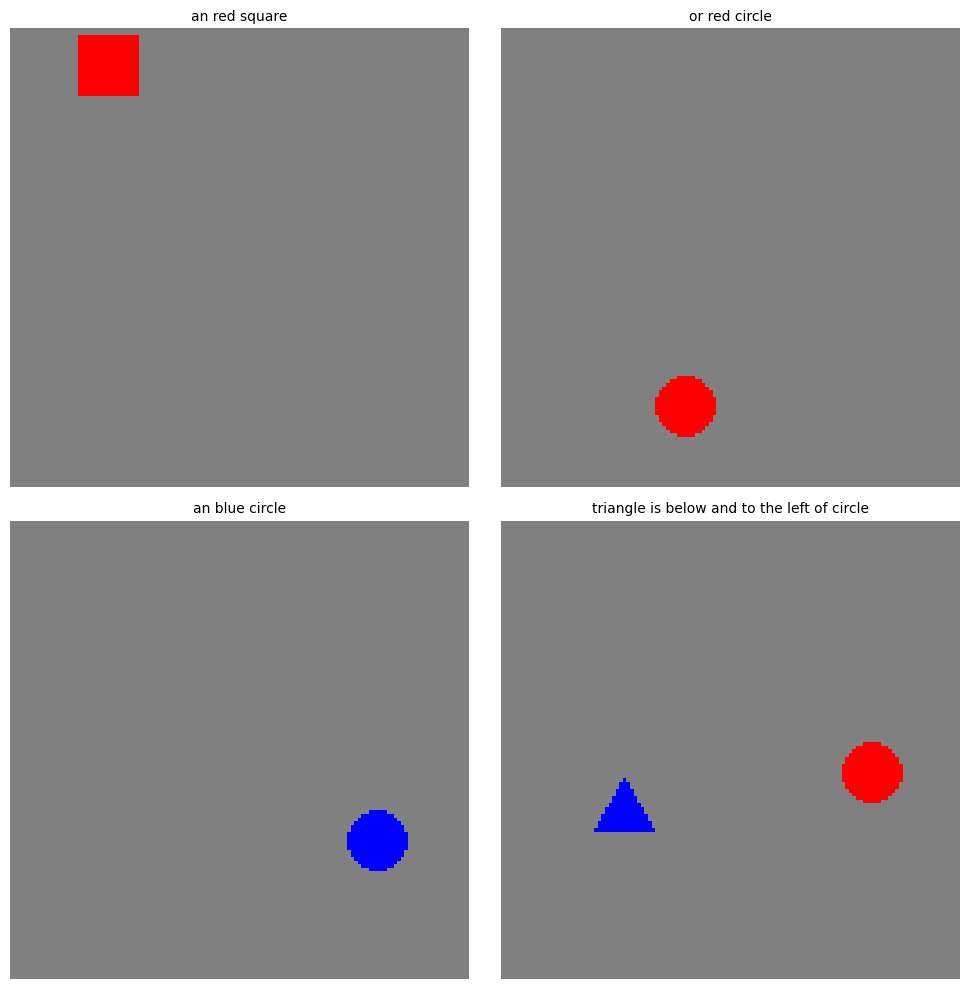

In [8]:
single_dataset = SingleShapeDataset(num_images=5000, resolution=128, radius=16)
double_dataset = DoubleShapeDataset(num_images=5000, resolution=128, radius=16)

#Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = MixedShapesDataset(single_dataset, double_dataset)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

for images, labels in dataloader:
    print(f"Images batch shape: {images.size()}")
    print(f"Labels batch: {labels}")
    print("Sample of batch captions:")
    for i in range(min(3, len(images))):
        print(f"Image {i}: {labels['caption'][i]}")
    break


#Check that the images and captions are correct visually

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.ravel()

for i in range(4):
    img, lbl = dataset[i]
    img_np = img.permute(1,2,0).numpy()

    axes[i].imshow(img_np)
    axes[i].set_title(lbl['caption'], fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

    

In [9]:
# Numerical inspections

images = []
labels = []

for i in range(10000):
    img, lbl = dataset[i]
    images.append(img)
    labels.append(lbl)

#Extract single object labels
image_tensors = torch.stack(images)
shape1 = torch.tensor([item['shape1'] for item in labels], dtype=torch.long)
location1 = torch.stack([item['location1'] for item in labels], dim=0)
shape2 = torch.tensor([item['shape2'] for item in labels], dtype=torch.long)
location2 = torch.stack([item['location2'] for item in labels], dim=0)

# Inspect image statistics
print("Mean pixel value:", image_tensors.mean().item())
print("Std dev of pixel values:", image_tensors.std().item())


#TODO: Ask Binxu about this batch stuff. what is going on under the hood?
#Inspect a batch
batch = next(iter(dataloader))
# images_batch, (shapes_batch, locations_batch) = batch

# print("Image batch shape:", images_batch.shape)
# print("Shapes batch shape:", shapes_batch.shape)
# print("Locations batch shape:", locations_batch.shape)



Mean pixel value: 0.4982169568538666
Std dev of pixel values: 0.07450460642576218


# Cache and reload the shape dataset

In [10]:
import os 
from os.path import join
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation"

save_path = os.path.join(savedir, 'shapes_dataset_multi_pilot1.pth')

os.makedirs(join(savedir, "dataset"), exist_ok=True)

torch.save({
    'images': image_tensors, 
    'shape1': shape1, 
    'location1': location1, 
    'shape2': shape2, 
    'location2':location2
}, save_path)


In [11]:
class ShapesDatasetCached(Dataset):
    filename = 'shapes_dataset_multi_pilot1.pth'
    savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation"

    def __init__(self, transform=None):
        '''
        Initializes the dataset. 

        Parameters:
        - transform: Optional torchvision transforms to apply to the images
        '''

        self.transform = transform
        self.data = torch.load(join(self.savedir, 'dataset', self.filename))
        self.images = self.data['images']
        self.shape1 = self.data['shape1']
        self.location1 = self.data['location1']
        self.shape2 = self.data['shape2']
        self.location2 = self.data['location2']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        shape1 = self.shape1[idx]
        location1 = self.location1[idx]
        shape2 = self.shape2[idx]
        location2 = self.location2[idx]

        if self.transform:
            img = self.transform(img)

        return img, (shape1, location1, shape2, location2)


In [12]:
#TODO: Ask Binxu about this transform stuff. 

dataset_cached = ShapesDatasetCached(
    transform = transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    )

    
dataset_cached[0][0]

/tmp/ipykernel_2625690/3169124329.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(join(self.savedir, 'dataset', self.filename))


tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.

In [11]:
image_tensors.shape

torch.Size([10000, 3, 128, 128])

# Convert to Pixart compatible training dataset 

# Encode Images with VAE

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae_model = "stabilityai/sd-vae-ft-ema"
vae = AutoencoderKL.from_pretrained(vae_model).to(device)


# Verify the autoencoder is working properly 
with torch.no_grad():
    latent_dist = vae.encode(image_tensors[0:1].to(device) * 2 - 1).latent_dist
    latent_mean = latent_dist.mean
    image_rec = vae.decode(latent_mean).sample * 0.5 + 0.5

image_rec.shape



torch.Size([1, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07874787..1.1714947].


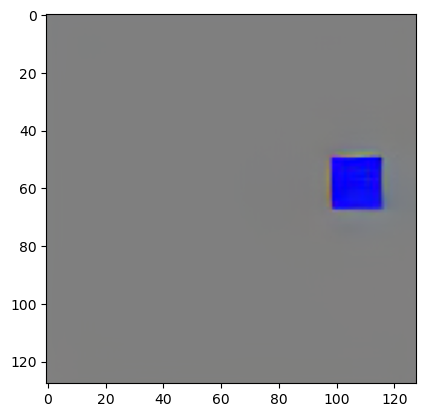

In [14]:
plt.imshow(image_rec[0].permute(1,2,0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.074810624..1.0840046].


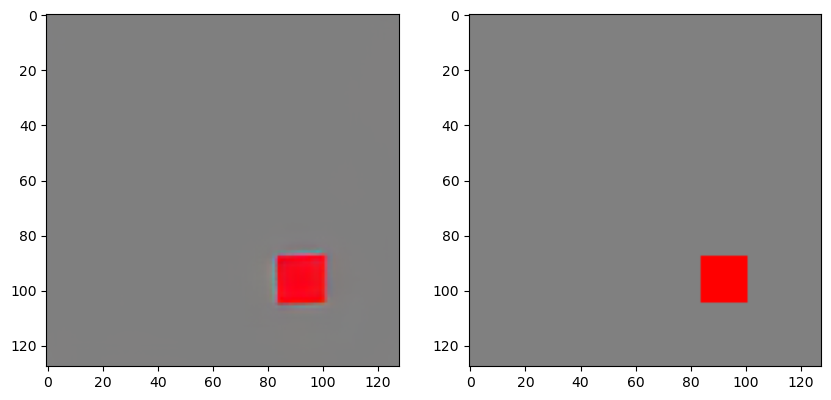

In [16]:
#Test that the encoder and decoder works 

image_tsr = dataset[0][0].unsqueeze(0)
with torch.no_grad():
    latent_dist = vae.encode(image_tsr.to(device) * 2 - 1).latent_dist
    latent_sample = latent_dist.sample()
    image_rec = vae.decode(latent_sample).sample * 0.5 + 0.5
    # latent_mean = latent_dist.mean
    # image_rec = vae.decode(latent_mean).sample * 0.5 + 0.5
image_rec.shape
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rec[0].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(image_tsr[0].permute(1, 2, 0).cpu().numpy())

In [19]:
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize, CenterCrop
# Save to persistent storage

transform = transforms.Compose([
    lambda x: x.convert("RGB")
])

resolution = 128

single_dataset = SingleShapeDataset(num_images=5000, resolution=128, radius=16)
double_dataset = DoubleShapeDataset(num_images=5000, resolution=128, radius=16)

dataset = MixedShapesDataset(single_dataset, double_dataset)

root_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1"
images_dir = "images"
captions_dir = "captions"

images_dir_absolute = join(root_dir, images_dir)
captions_dir_absolute = join(root_dir, captions_dir)

if not os.path.exists(root_dir):
    os.makedirs(join(root_dir, images_dir))

if not os.path.exists(join(root_dir, images_dir)):
    os.makedirs(join(root_dir, captions_dir))
if not os.path.exists(join(root_dir, captions_dir)):
    os.makedirs(join(root_dir, captions_dir))


image_format = "png"
json_name = "partition/data_info.json"
if not os.path.exists(join(root_dir, "partition")):
    os.makedirs(join(root_dir, "partition"))

absolute_json_name = join(root_dir, json_name)
data_info = []

for order, (image, labels) in tqdm(enumerate(dataset)):
    if order >= 10000:
        break

    image_pil = ToPILImage()(image)
    image_pil.save(f"{images_dir_absolute}/{order}.{image_format}")
    with open(f"{captions_dir_absolute}/{order}.txt", "w") as text_file:
        text_file.write(labels["caption"])

    width, height = resolution, resolution
    ratio = 1
    data_info.append({
        "height": height,
        "width": width,
        "ratio": ratio,
        "path": f"{order}.{image_format}",
        "prompt": labels["caption"]
    })

with open(absolute_json_name, "w") as json_file:
    json.dump(data_info, json_file)



0it [00:00, ?it/s]

# Extract Features 

In [20]:
%cd ../PixArt-alpha
!python ~/Github/DiffusionObjectRelation/PixArt-alpha/tools/extract_features.py \
    --img_size 128 \
    --max_tokens 20 \
    --dataset_root "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1" \
    --json_path "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/partition/data_info.json" \
    --t5_save_root "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/caption_feature_wmask" \
    --vae_save_root "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/img_vae_features" \
    --pretrained_models_dir "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models"

/n/home12/hjkim/Github/DiffusionObjectRelation/PixArt-alpha
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. 

In [21]:
!du -sh /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/*

1.5G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/caption_feature_wmask
40M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/captions
40M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/images
118M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/img_vae_features_128resolution
1.1M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRelMulti_pilot1/partition


# Training